In [1]:
#!pip install yfinance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pypfopt

# Import Data
Download data from yahoo finance directly instead of referencing csv

In [20]:
symbols_list = ['AAPL', 'AXP', 'UAA', 'APA', 'SU', 'NFLX', 'XRX','AMZN', 'KO', 'TSLA']
stock_data = yf.download(symbols_list, start="2000-01-01", end="2020-01-01")
prices = stock_data["Adj Close"]
print(prices.shape)
prices.head()

[*********************100%***********************]  10 of 10 completed
(5033, 10)


,AAPL,AMZN,APA,AXP,KO,NFLX,SU,TSLA,UAA,XRX
Date,,,,,,,,,,
1999-12-31,0.793253,76.1250,12.651278,36.351334,12.204452,NaN,3.542891,NaN,NaN,40.190422
2000-01-03,0.863657,89.3750,11.687977,34.383446,11.811604,NaN,3.479247,NaN,NaN,42.847652
2000-01-04,0.790842,81.9375,11.174217,33.085163,11.824701,NaN,3.595926,NaN,NaN,40.854725
2000-01-05,0.802415,69.7500,11.495318,32.244839,11.929461,NaN,3.903542,NaN,NaN,42.958355
2000-01-06,0.732975,65.5625,12.587049,32.901760,11.942557,NaN,3.797466,NaN,NaN,42.072613


In [21]:
market_prices = yf.download("SPY", start="2000-01-01", end="2020-01-01")["Adj Close"]
print(market_prices.shape)
market_prices.tail()

[*********************100%***********************]  1 of 1 completed
(5032,)


Date
2019-12-24    316.685272
2019-12-26    318.371063
2019-12-27    318.292175
2019-12-30    316.537384
2019-12-31    317.306335
Name: Adj Close, dtype: float64

In [22]:
mkt_caps = {}
for symbol in symbols_list:
    stock = yf.Ticker(symbol)
    print(stock.info["marketCap"])
    mkt_caps[symbol] = stock.info["marketCap"]

mkt_caps

1968155656192
83237543936
5169961984
3612282624
18332688384
235793072128
4396059648
1600689143808
212881997824
396298354688


{'AAPL': 1968155656192,
 'AXP': 83237543936,
 'UAA': 5169961984,
 'APA': 3612282624,
 'SU': 18332688384,
 'NFLX': 235793072128,
 'XRX': 4396059648,
 'AMZN': 1600689143808,
 'KO': 212881997824,
 'TSLA': 396298354688}

# Constructing the prior

The prior distribution is the historical distribution of our stock's returns, volatility and covariance

In [23]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

1.5578327076007414

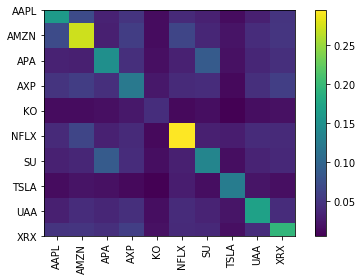

In [24]:
# Variance-Covariance matrix
plotting.plot_covariance(S);

In [25]:
market_prior = black_litterman.market_implied_prior_returns(mkt_caps, delta, S)
market_prior

AAPL    0.177971
AMZN    0.229886
APA     0.068878
AXP     0.095943
KO      0.045117
NFLX    0.114235
SU      0.070303
TSLA    0.062461
UAA     0.074200
XRX     0.090601
dtype: float64

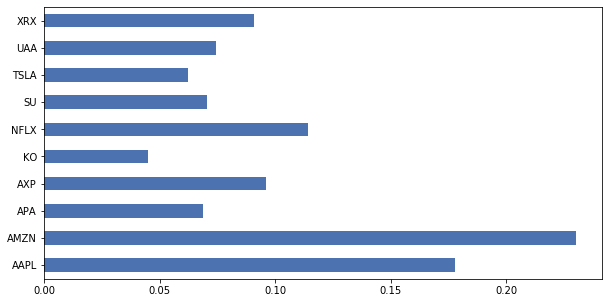

In [26]:
market_prior.plot.barh(figsize=(10,5));

# Personal investment views
Black Litterman model gives us the option to include our own personal investment beliefs of the range in which a stocks returns may vary, as well as our confidence intervals in these beliefs

In [27]:
# You don't have to provide views on all the assets
viewdict = {
    "AAPL": 0.10, # I think Apple will go up 10%
    "APA": 0.25,
    "AXP": 0.05,
    "XRX": 0.05,
    "AMZN": 0.30, 
    "NFLX": 0.30,
    "UAA": 0.15,
    "SU": 0.10,
    "KO": 0.10,
    "TSLA": 0.30
}

intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.05, 0.20),
    (-0.05, 0.10),
    (0.20, 0.35),
    (0.20, 0.45),
    (0.00, 0.2),
    (0.08, 0.12),
    (0.1, 0.2),
    (0.10, 0.50)
]


variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

bl = BlackLittermanModel(S, pi="market", market_caps=mkt_caps, risk_averison="delta", absolute_views=viewdict, omega=omega)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.005624999999999997, 0.015625, 0.010000000000000002, 0.00039999999999999986, 0.0025000000000000005, 0.04000000000000001]


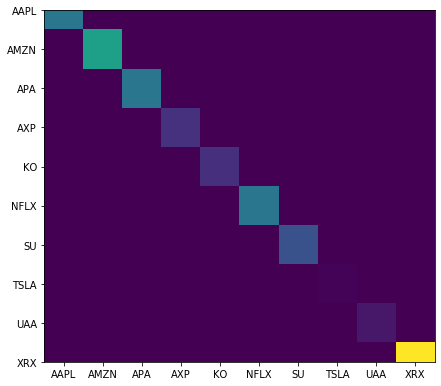

In [28]:
# Shows investor's forward view
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

# Estimate posterior returns
In layman terms:

Expected excess returns = Investor view * Past Market view

$$E(R-R_{rf}) = [(\tau*S)^{-1} + P^\text{T}\Omega^{-1}P]^{-1}]*[(\tau*S)^{-1}\Pi + P^\text{T}\Omega^{-1}Q]$$

$E(R-R_{rf}) = \text{Expected excess return}$

$P = \text{Matrix identifying which stocks you have views about}$

$Q = \text{Matrix of investor forward view of excess returns}$

$S = \text{Variance-Covariance Matrix}$

$\tau = \text{Scalar assume = 1}$

$\Omega = \text{Uncertainty surrounding your future views}$

$\Pi = \text{Implied excess returns derived from prior}$



In [29]:
ret_bl = bl.bl_returns()
ret_bl

AAPL    0.135938
AMZN    0.236874
APA     0.113594
AXP     0.092518
KO      0.060866
NFLX    0.199344
SU      0.099436
TSLA    0.114196
UAA     0.115266
XRX     0.075401
dtype: float64

In [30]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.177971,0.135938,0.10
AMZN,0.229886,0.236874,0.30
APA,0.068878,0.113594,0.25
AXP,0.095943,0.092518,0.05
KO,0.045117,0.060866,0.10
NFLX,0.114235,0.199344,0.30
SU,0.070303,0.099436,0.10
TSLA,0.062461,0.114196,0.30
UAA,0.074200,0.115266,0.15
XRX,0.090601,0.075401,0.05


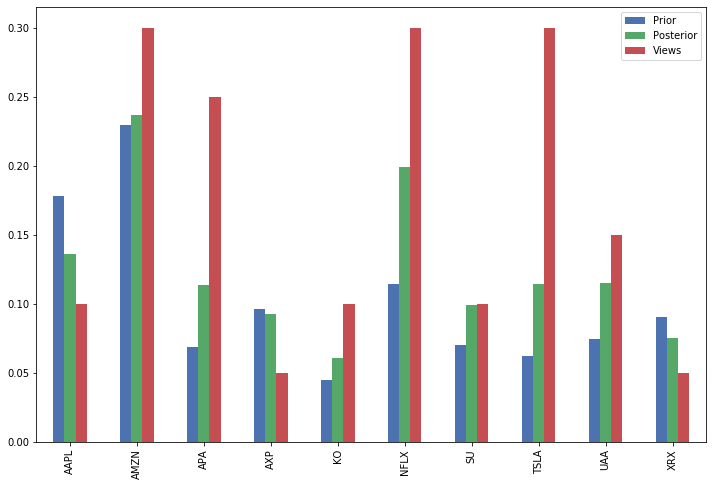

In [31]:
rets_df.plot.bar(figsize=(12,8));

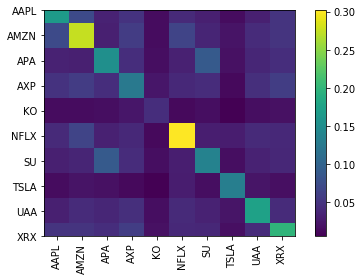

In [32]:
# Estimate of covariance matrix, factoring investor views
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [33]:
from pypfopt import EfficientFrontier, objective_functions
ef = EfficientFrontier(ret_bl, S_bl, weight_bounds=(0,0.25))
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.add_constraint(lambda x : x >= 0.025)
ef.max_sharpe()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.10748),
             ('AMZN', 0.23836),
             ('APA', 0.09066),
             ('AXP', 0.025),
             ('KO', 0.06572),
             ('NFLX', 0.1657),
             ('SU', 0.0461),
             ('TSLA', 0.15682),
             ('UAA', 0.07915),
             ('XRX', 0.025)])

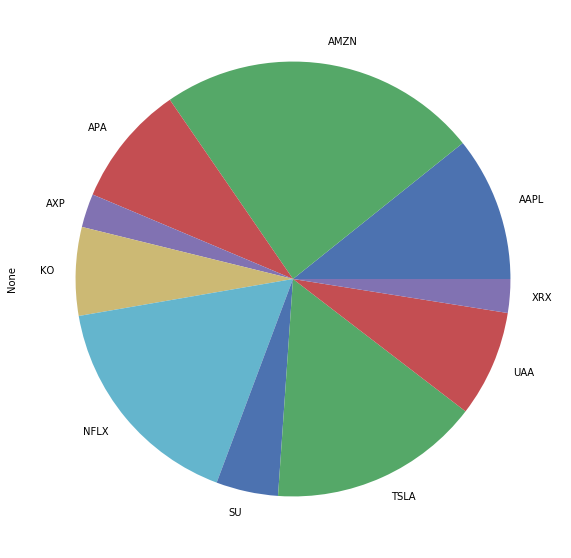

In [34]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [35]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=100000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $3.76


{'AAPL': 146.0,
 'AMZN': 13.0,
 'APA': 359.0,
 'AXP': 21.0,
 'KO': 122.0,
 'NFLX': 51.0,
 'SU': 145.0,
 'TSLA': 186.0,
 'UAA': 367.0,
 'XRX': 71.0}

In [36]:
print("Black-Litterman Portfolio Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (ef.portfolio_performance()))

Black-Litterman Portfolio Analysis:
	Expected annual return: 0.154217
	Annual Volatility: 0.249915
	Sharpe ratio: 0.537049


# Allow shorting
Allow the portfolio to allocate negative weights by shorting stocks

In [37]:
ef_with_short = EfficientFrontier(ret_bl, S_bl, weight_bounds=(-1,1))
ef_with_short.add_objective(objective_functions.L2_reg, gamma=0.1)
ef_with_short.max_sharpe()
weights_with_short = ef_with_short.clean_weights()
weights_with_short

OrderedDict([('AAPL', 0.11884),
             ('AMZN', 0.24843),
             ('APA', 0.09993),
             ('AXP', 0.00742),
             ('KO', 0.07562),
             ('NFLX', 0.17243),
             ('SU', 0.05344),
             ('TSLA', 0.16303),
             ('UAA', 0.08815),
             ('XRX', -0.0273)])

In [38]:
print("Black-Litterman with shorts Portfolio Analysis:")
print("\tExpected annual return: %f\n\tAnnual Volatility: %f\n\tSharpe ratio: %f" % (ef_with_short.portfolio_performance()))

Black-Litterman with shorts Portfolio Analysis:
	Expected annual return: 0.158049
	Annual Volatility: 0.253626
	Sharpe ratio: 0.544301
